# Regridding using ESMF with xESMF and ESMPy wrappers

In [1]:
# download our WOA data
#!wget https://data.nodc.noaa.gov/woa/WOA13/DATA/temperature/netcdf/5564/1.00/woa13_5564_t00_01.nc

byrd=False

if not byrd:
    woadir = '../using_f2py/'
else:
    woadir = '~rdussin/demo_files/'

In [2]:
import xarray as xr
import matplotlib.pylab as plt
from matplotlib import cm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/5.1.0/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
woa = xr.open_dataset(woadir + 'woa13_5564_t00_01.nc',decode_times=False)

In [4]:
# download a ROMS irregular grid 


if not byrd:
    !wget http://oceanus.esm.rutgers.edu:8080/thredds/fileServer/ROMS/NWA/Inputs/NWA_grd.nc
    romsdir = './'
else:
    romsdir = '~rdussin/demo_files/'

--2018-05-23 16:34:01--  http://oceanus.esm.rutgers.edu:8080/thredds/fileServer/ROMS/NWA/Inputs/NWA_grd.nc
Resolving oceanus.esm.rutgers.edu (oceanus.esm.rutgers.edu)... 165.230.173.131
Connecting to oceanus.esm.rutgers.edu (oceanus.esm.rutgers.edu)|165.230.173.131|:8080... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71046252 (68M) [application/x-netcdf]
Saving to: ‘NWA_grd.nc.1’

NWA_grd.nc.1         10%[=>                  ]   6.89M  1.08MB/s    eta 64s    ^C


In [5]:
roms_nwa = xr.open_dataset(romsdir + 'NWA_grd.nc')

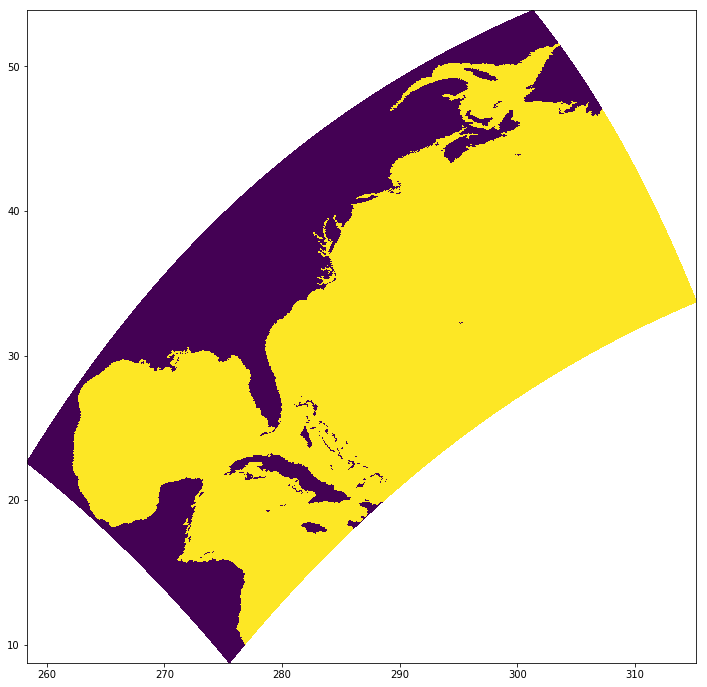

In [6]:
plt.figure(figsize=[12,12])
plt.pcolormesh(roms_nwa['lon_vert'].values,roms_nwa['lat_vert'].values,roms_nwa['mask_rho'].values)
plt.show()

## The easy way 

In [7]:
import xesmf as xe

In [8]:
woa
roms_nwa.rename({'lon_rho':'lon','lat_rho':'lat'},inplace=True)
roms_nwa

<xarray.Dataset>
Dimensions:     (bath: 1, eta_psi: 361, eta_rho: 362, eta_u: 362, eta_v: 361, eta_vert: 363, s_rho: 40, s_w: 41, xi_psi: 721, xi_rho: 722, xi_u: 721, xi_v: 722, xi_vert: 723)
Coordinates:
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 -0.9125 -0.8875 ...
  * s_w         (s_w) float64 -1.0 -0.975 -0.95 -0.925 -0.9 -0.875 -0.85 ...
Dimensions without coordinates: bath, eta_psi, eta_rho, eta_u, eta_v, eta_vert, xi_psi, xi_rho, xi_u, xi_v, xi_vert
Data variables:
    theta_s     float64 ...
    theta_b     float64 ...
    Tcline      float64 ...
    hc          float64 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float64 ...
    hraw        (bath, eta_rho, xi_rho) float64 ...
    f           (eta_rho, xi_rho) float64 ...
    pm          (eta_rho, xi_rho) float64 ...
    pn          (eta_rho, xi_rho) float64 ...
    dmde        (eta_rho, xi_rho) float64 ...
    dndx        (eta_rho, xi_rho) float64 ...


In [ ]:
regrider = xe.Regridder?

In [11]:
regrid_patch = xe.Regridder(woa,roms_nwa,method='patch',periodic=True)
# other method are possible : bilinear, nearest neighbor,...

Overwrite existing file: patch_180x360_362x722_peri.nc 
 You can set reuse_weights=True to save computing time.


In [12]:
temp_out = regrid_patch(woa['t_an'])

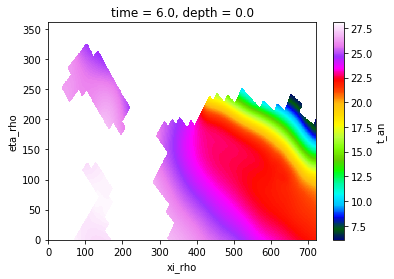

In [13]:
temp_out.sel(depth=0).plot(cmap=cm.gist_ncar)

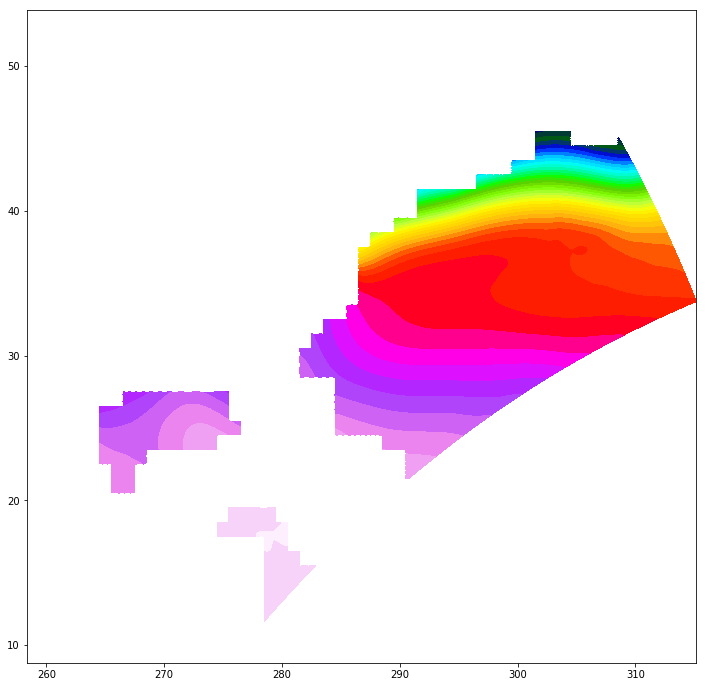

In [14]:
plt.figure(figsize=[12,12])
plt.contourf(roms_nwa['lon'].values,roms_nwa['lat'].values,temp_out.sel(depth=0).values.squeeze(),50,cmap=cm.gist_ncar)
plt.show()

## The not so easy way 

In [15]:
import ESMF

### Let's create a raw bathymetry

In [17]:
roms_nwa = xr.open_dataset(romsdir + 'NWA_grd.nc')

#### ROMS ESMF grid

In [18]:
# create an ESMF target grid corresponding to our ROMS grid

ny_target, nx_target = roms_nwa.lon_rho.shape
esmf_grid_target = ESMF.Grid(np.array([nx_target,ny_target]))
# cell center
esmf_grid_target.add_coords(staggerloc=[ESMF.StaggerLoc.CENTER])
esmf_grid_target.coords[ESMF.StaggerLoc.CENTER]
esmf_grid_target.coords[ESMF.StaggerLoc.CENTER][0][:]=roms_nwa.lon_rho.transpose()
esmf_grid_target.coords[ESMF.StaggerLoc.CENTER][1][:]=roms_nwa.lat_rho.transpose()
# cell corner
esmf_grid_target.add_coords(staggerloc=[ESMF.StaggerLoc.CORNER_VCENTER])
esmf_grid_target.coords[ESMF.StaggerLoc.CORNER_VCENTER]
esmf_grid_target.coords[ESMF.StaggerLoc.CORNER_VCENTER][0][:]=roms_nwa.lon_vert.transpose()
esmf_grid_target.coords[ESMF.StaggerLoc.CORNER_VCENTER][1][:]=roms_nwa.lat_vert.transpose()
# VERY IMPORTANT! if not set properly, this ruins the interpolation process
# our domain is regional/not global, hence we must set:
esmf_grid_target.is_sphere=False

#### Etopo ESMF grid

In [19]:
# Bathy is taken from ETOPO1 website, select area and export to netcdf
# my extraction is on byrd : ~rdussin/demo_files

if byrd:
    topodir = '~rdussin/demo_files/'
else:
    topodir = './'

In [20]:
# if we were using bilinear interpolation, we could use the ESMF built-in function to
# read bathy file into grid object
# esmf_grid_source = ESMF.Grid(filename='etopo1_bedrock.nc',filetype=ESMF.FileFormat.GRIDSPEC,is_sphere=False)

# However it doesn't include the corners so we can either add the lon_bounds and lat_bounds array to the
# file and add add_corner_stagger=True to the previous command or we can just read lon/lat from the file
# and add the corners manually

# read coords from netcdf file
etopo = xr.open_dataset(topodir + 'etopo1_bedrock.nc')
lon = etopo['lon'].values[::10]
lat = etopo['lat'].values[::10]

## VERY IMPORTANT !! I subsample for the sake of computational speed for demo purposes
## don't do this in real like, that defeats the whole purpose

# compute the extended array at cell center
nx = lon.shape[0] ; ny = lat.shape[0]

lon_extended = np.zeros((nx+2))
lon_extended[1:-1] = lon.copy()
lon_extended[0] = lon[0] - (lon[1]-lon[0])
lon_extended[-1] = lon[-1] + (lon[-1]-lon[-2])

lat_extended = np.zeros((ny+2))
lat_extended[1:-1] = lat.copy()
lat_extended[0] = max(-90. , lat[0] - (lat[1]-lat[0]))
lat_extended[-1] = min(90. , lat[-1] + (lat[-1]-lat[-2]))

# compute the cell corner values
lon_corner = 0.5 * (lon_extended[:-1] + lon_extended[1:])
lat_corner = 0.5 * (lat_extended[:-1] + lat_extended[1:])

# make them 2d arrays
lon_centers, lat_centers = np.meshgrid(lon,lat)
lon_corners, lat_corners = np.meshgrid(lon_corner,lat_corner)

# create an ESMF grid for the input bathy and add lon/lat for cells
esmf_grid_source = ESMF.Grid(np.array([nx,ny]))
# cell center
esmf_grid_source.add_coords(staggerloc=[ESMF.StaggerLoc.CENTER])
esmf_grid_source.coords[ESMF.StaggerLoc.CENTER]
esmf_grid_source.coords[ESMF.StaggerLoc.CENTER][0][:]=lon_centers.T
esmf_grid_source.coords[ESMF.StaggerLoc.CENTER][1][:]=lat_centers.T
#cell corners
esmf_grid_source.add_coords(staggerloc=[ESMF.StaggerLoc.CORNER_VCENTER])
esmf_grid_source.coords[ESMF.StaggerLoc.CORNER_VCENTER]
esmf_grid_source.coords[ESMF.StaggerLoc.CORNER_VCENTER][0][:]=lon_corners.T
esmf_grid_source.coords[ESMF.StaggerLoc.CORNER_VCENTER][1][:]=lat_corners.T
# our input bathy data is a regional extraction, hence we must set:
esmf_grid_source.is_sphere=False

#### run the regridding

we are running a conservative regridding so conserve water depth. This step is gonna take a few minutes so it's a good time to go get a coffee 

In [21]:
# Create a source field object for bathy located at the center of the grid cells
esmf_field_source = ESMF.Field(esmf_grid_source, staggerloc=ESMF.StaggerLoc.CENTER)

# and feed it to the field object
esmf_field_source.data[:] = etopo.Band1.values[::10,::10].transpose() # CAREFUL : SUBSAMPLING FOR DEMO

# Create a destination field object on the ROMS grid
esmf_field_target = ESMF.Field(esmf_grid_target, staggerloc=ESMF.StaggerLoc.CENTER)

# Set up a regridding method between source and destination
regridding = ESMF.Regrid(esmf_field_source, esmf_field_target,
                         regrid_method=ESMF.RegridMethod.CONSERVE)

esmf_field_target = regridding(esmf_field_source, esmf_field_target)

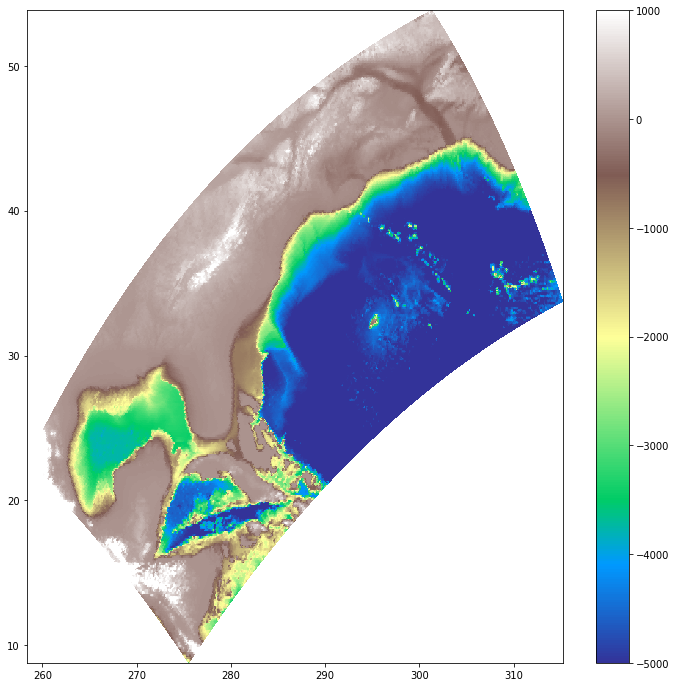

In [22]:
# Check out our freshly interpolated bathymetry
topo = esmf_field_target.data[:].transpose()

plt.figure(figsize=[12,12])
plt.pcolormesh(roms_nwa.lon_rho,roms_nwa.lat_rho,topo,cmap=cm.terrain); plt.colorbar() ; plt.clim([-5000.,1000])
plt.show()